# Importing Libraries

In [ ]:
import os
# Set TensorFlow's minimum log level to 2, suppressing info and debug messages to reduce log noise.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from keras.preprocessing.image import load_img ,img_to_array
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from nltk.translate.bleu_score import corpus_bleu

#Importing Data

In [ ]:
images_directory = '/content/drive/MyDrive/Colab_Notebooks/Projects/Image_Captionning/DataSet/Images'
captions_path = '/content/drive/MyDrive/Colab_Notebooks/Projects/Image_Captionning/DataSet/captions.txt'

# importing data from captions.txt file
with open(captions_path , 'r') as f:
  #  import each line as an element of our lines list
  lines = f.readlines()
  # lowercasing the data , removing the first line because it contains just the name of the column
  lines = [line.lower() for line in lines[1:]]

lines[:15:3]

['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .\n']

# Data PreProcessing


In [ ]:
processed_captions = []

for line in lines:
  caption = line.split(',')[1]
  # Removing all special characters (punctuation, symbols, etc..)
  caption = re.sub(r'[^\w\s]', '', caption)
  # Removing all sequences consisting of one or more digits from the string.
  caption = re.sub(r'\d+', '', caption)
  # Removing extra whitespace
  caption = re.sub(r'\s+', ' ', caption).strip()

  processed_captions.append(caption)

processed_captions[:15:2]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing into a wooden playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a tricolored dog playing with each other on the road',
 'two dogs of different breeds looking at each other on the road',
 'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'young girl with pigtails painting outside in the grass']

In [ ]:
new_lines = []
for i in range(len(processed_captions)):
  # adding the 'start' to the caption as an input and 'end' to mark the end of the caption for the LSTM model
  new_line = lines[i].split(',')[0] + '\t' + 'start '+ processed_captions[i] + ' end\n'
  new_lines.append(new_line)

new_lines[:20:3] , len(new_lines)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

# Data Visualization

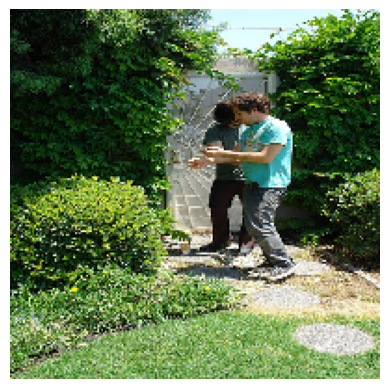

Caption: white males are outside near many bushes.


In [ ]:
for line in lines[:1]:
    # Split the line to get the file name and the caption
    filename, caption = line.split(',')[0], line.split(',')[1].strip()

    # Load the image
    image_load = load_img(images_directory + '/' + filename.strip(), target_size=(199, 199))

    # Display the image
    plt.imshow(image_load)
    # Disable the axes
    plt.axis('off')
    plt.show()
    print("Caption:", caption)

In [ ]:
# Create an empty set to store unique words
unique_words = set()
for sentence in processed_captions:
    words = word_tokenize(sentence)
    unique_words.update(words)

vocab_size = len(unique_words)
print('the size of the vocabulary is : ', vocab_size)

the size of the vocabulary is :  8586


# Data Splitting

In [ ]:
# Storing all image IDs
ids = os.listdir(images_directory)

# Splitting the Data
train_ids , test_ids = train_test_split(ids , test_size = 0.15 , random_state =42)
val_ids , test_ids = train_test_split(test_ids , test_size = 0.1 , random_state =42)

train_id_and_captions, val_id_and_captions, test_id_and_captions = [], [], []
for line in new_lines:
    image_id, _ = line.split('\t')

    if image_id in train_ids:
        train_id_and_captions.append(line)

    elif image_id in val_ids:
        val_id_and_captions.append(line)

    elif image_id in test_ids:
        test_id_and_captions.append(line)

    else:
        print('Image ID not found!')


train_id_and_captions[0], test_id_and_captions[0], val_id_and_captions[0], len(train_id_and_captions)/5, len(test_id_and_captions)/5, len(val_id_and_captions)/5

('1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 '1001773457_577c3a7d70.jpg\tstart a black dog and a spotted dog are fighting end\n',
 '1042590306_95dea0916c.jpg\tstart a man and woman pose for the camera while another man looks on end\n',
 6877.0,
 1092.0,
 122.0)

# Data Preparation For the CNN Model

In [ ]:
def image_processing_for_model(image_path):
    image = load_img(image_path, target_size=(299, 299))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    # Preprocessing the image to adapt it to the specifications of the InceptionV3 model
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image

def image_features_extraction(cnn_model, image_path):
    image = image_processing_for_model(image_path)
    img_features = cnn_model.predict(image, verbose=0)
    return img_features

# Loading the pre-trained Model (InceptionV3)

In [ ]:
inceptionV3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))

96112376/96112376 [==============================] - 1s 0us/step


In [ ]:
inceptionV3_model = Model(inputs=inceptionV3_model.inputs, outputs=inceptionV3_model.layers[-2].output)

In [ ]:
train_image_features, val_image_features, test_image_features = {}, {}, {}  # A Dictionary to store image features with their corresponding IDs


for image_id in ids:

    image_path = os.path.join(images_directory, image_id)
    image_features = image_features_extraction(inceptionV3_model, image_path)

    if image_id in train_ids:
        train_image_features[image_id] = image_features.flatten()

    elif image_id in val_ids:
        val_image_features[image_id] = image_features.flatten()

    elif image_id in test_ids:
        test_image_features[image_id] = image_features.flatten()

    else:
        print('Image ID not found!')

In [ ]:
tokenizer_instance = Tokenizer()
tokenizer_instance.fit_on_texts(processed_captions)

# Defining the maximum length of captions
caption_max_length = max(len(caption.split()) for caption in processed_captions) + 1

# Defining batch size
batch_size_train = 270
batch_size_val = 150

# Defining the CNN output dimension (size of feature vector from InceptionV3)
output_dim_of_cnn_model = inceptionV3_model.output_shape[1]

In [ ]:
def batch_data_generator(captions, image_features, tokenizer_instance, caption_max_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())

    while True:

        np.random.shuffle(image_ids)

        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []

            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer_instance.texts_to_sequences([caption_text])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=caption_max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)

            yield [np.array(X_images), np.array(X_captions)], np.array(y)

In [ ]:
# Creating data generators for training and validation
train_data_generator = batch_data_generator(train_id_and_captions, train_image_features, tokenizer_instance, caption_max_length, batch_size_train)
val_data_generator = batch_data_generator(val_id_and_captions, val_image_features, tokenizer_instance, caption_max_length, batch_size_val)

# Modeling

In [ ]:
def build_model(vocab_size, caption_max_length, output_dim_of_cnn_model):

    # Encoder Model
    input_image = Input(shape=(output_dim_of_cnn_model,), name='Features_Input')

    # BatchNormalization: Stabilizes learning by reducing the change in activation distribution,
    # reduces covariate shift between layers,
    # acts as regularization by adding noise to activations, and makes the model less sensitive to scale variations.
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1) # Adding a Dense layer to the CNN output to match the decoder output size
    fe3 = BatchNormalization()(fe2)


    # Decoder Model
    input_caption = Input(shape=(caption_max_length,), name='Sequence_Input')

    # takes the integer-encoded vocabulary and looks up the embedding vector for each word-index
    # Embedding layer are adjusted in order to optimize the performance of the model
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    # 256 : the dim of the hidden state
    se2 = LSTM(256)(se1)

    # Output
    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    # Returning The Model
    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model

# Building the model
caption_model = build_model(vocab_size, caption_max_length, output_dim_of_cnn_model)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)

caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

caption_model.summary()

Model: "Image_Captioning"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Features_Input (InputLayer)    [(None, 2048)]       0           []                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, 2048)        8192        ['Features_Input[0][0]']         
 ormalization)                                                                                    
                                                                                                  
 Sequence_Input (InputLayer)    [(None, 34)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['batch_normalizat

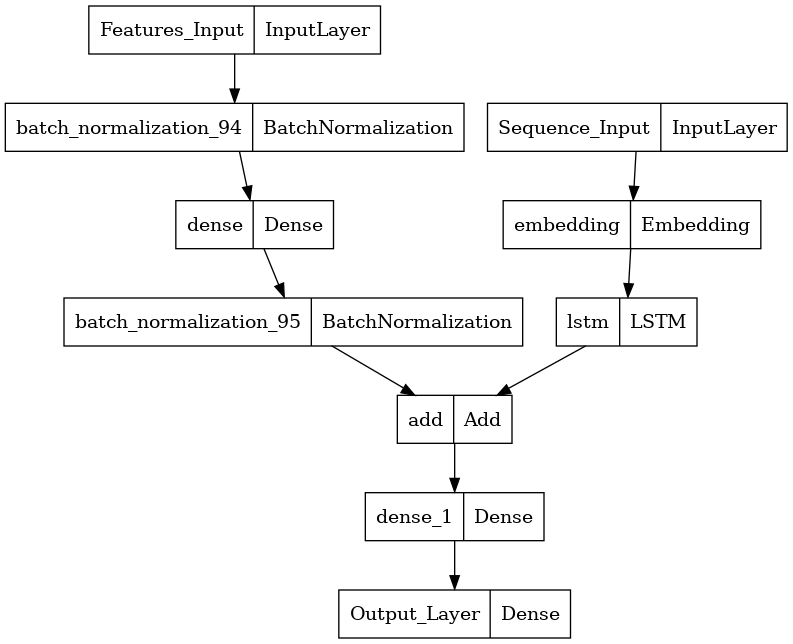

In [ ]:
plot_model(caption_model)

# Training the Model

In [ ]:
# Defining early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return lr * tf.math.exp(-0.6)

# Learning Rate Scheduler
lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(train_data_generator, steps_per_epoch=len(train_id_and_captions) // batch_size_train,
                        validation_data=val_data_generator, validation_steps=len(val_id_and_captions) // batch_size_val,
                        epochs=15, callbacks=[early_stopping, lr_schedule])

Epoch 1/15
127/127 [==============================] - 59s 412ms/step - loss: 4.5193 - val_loss: 3.7587 - lr: 0.0055
Epoch 2/15
127/127 [==============================] - 46s 363ms/step - loss: 3.2788 - val_loss: 3.3721 - lr: 0.0030
Epoch 3/15
127/127 [==============================] - 46s 367ms/step - loss: 2.8868 - val_loss: 3.2566 - lr: 0.0017
Epoch 4/15
127/127 [==============================] - 46s 364ms/step - loss: 2.6674 - val_loss: 3.2166 - lr: 9.0718e-04
Epoch 5/15
127/127 [==============================] - 46s 365ms/step - loss: 2.5308 - val_loss: 3.2102 - lr: 4.9787e-04
Epoch 6/15
127/127 [==============================] - 46s 361ms/step - loss: 2.4477 - val_loss: 3.2135 - lr: 2.7324e-04
Epoch 7/15
127/127 [==============================] - 46s 364ms/step - loss: 2.3978 - val_loss: 3.2198 - lr: 1.4996e-04
Epoch 8/15
127/127 [==============================] - 46s 362ms/step - loss: 2.3697 - val_loss: 3.2241 - lr: 8.2297e-05


### Visualizing the model performance

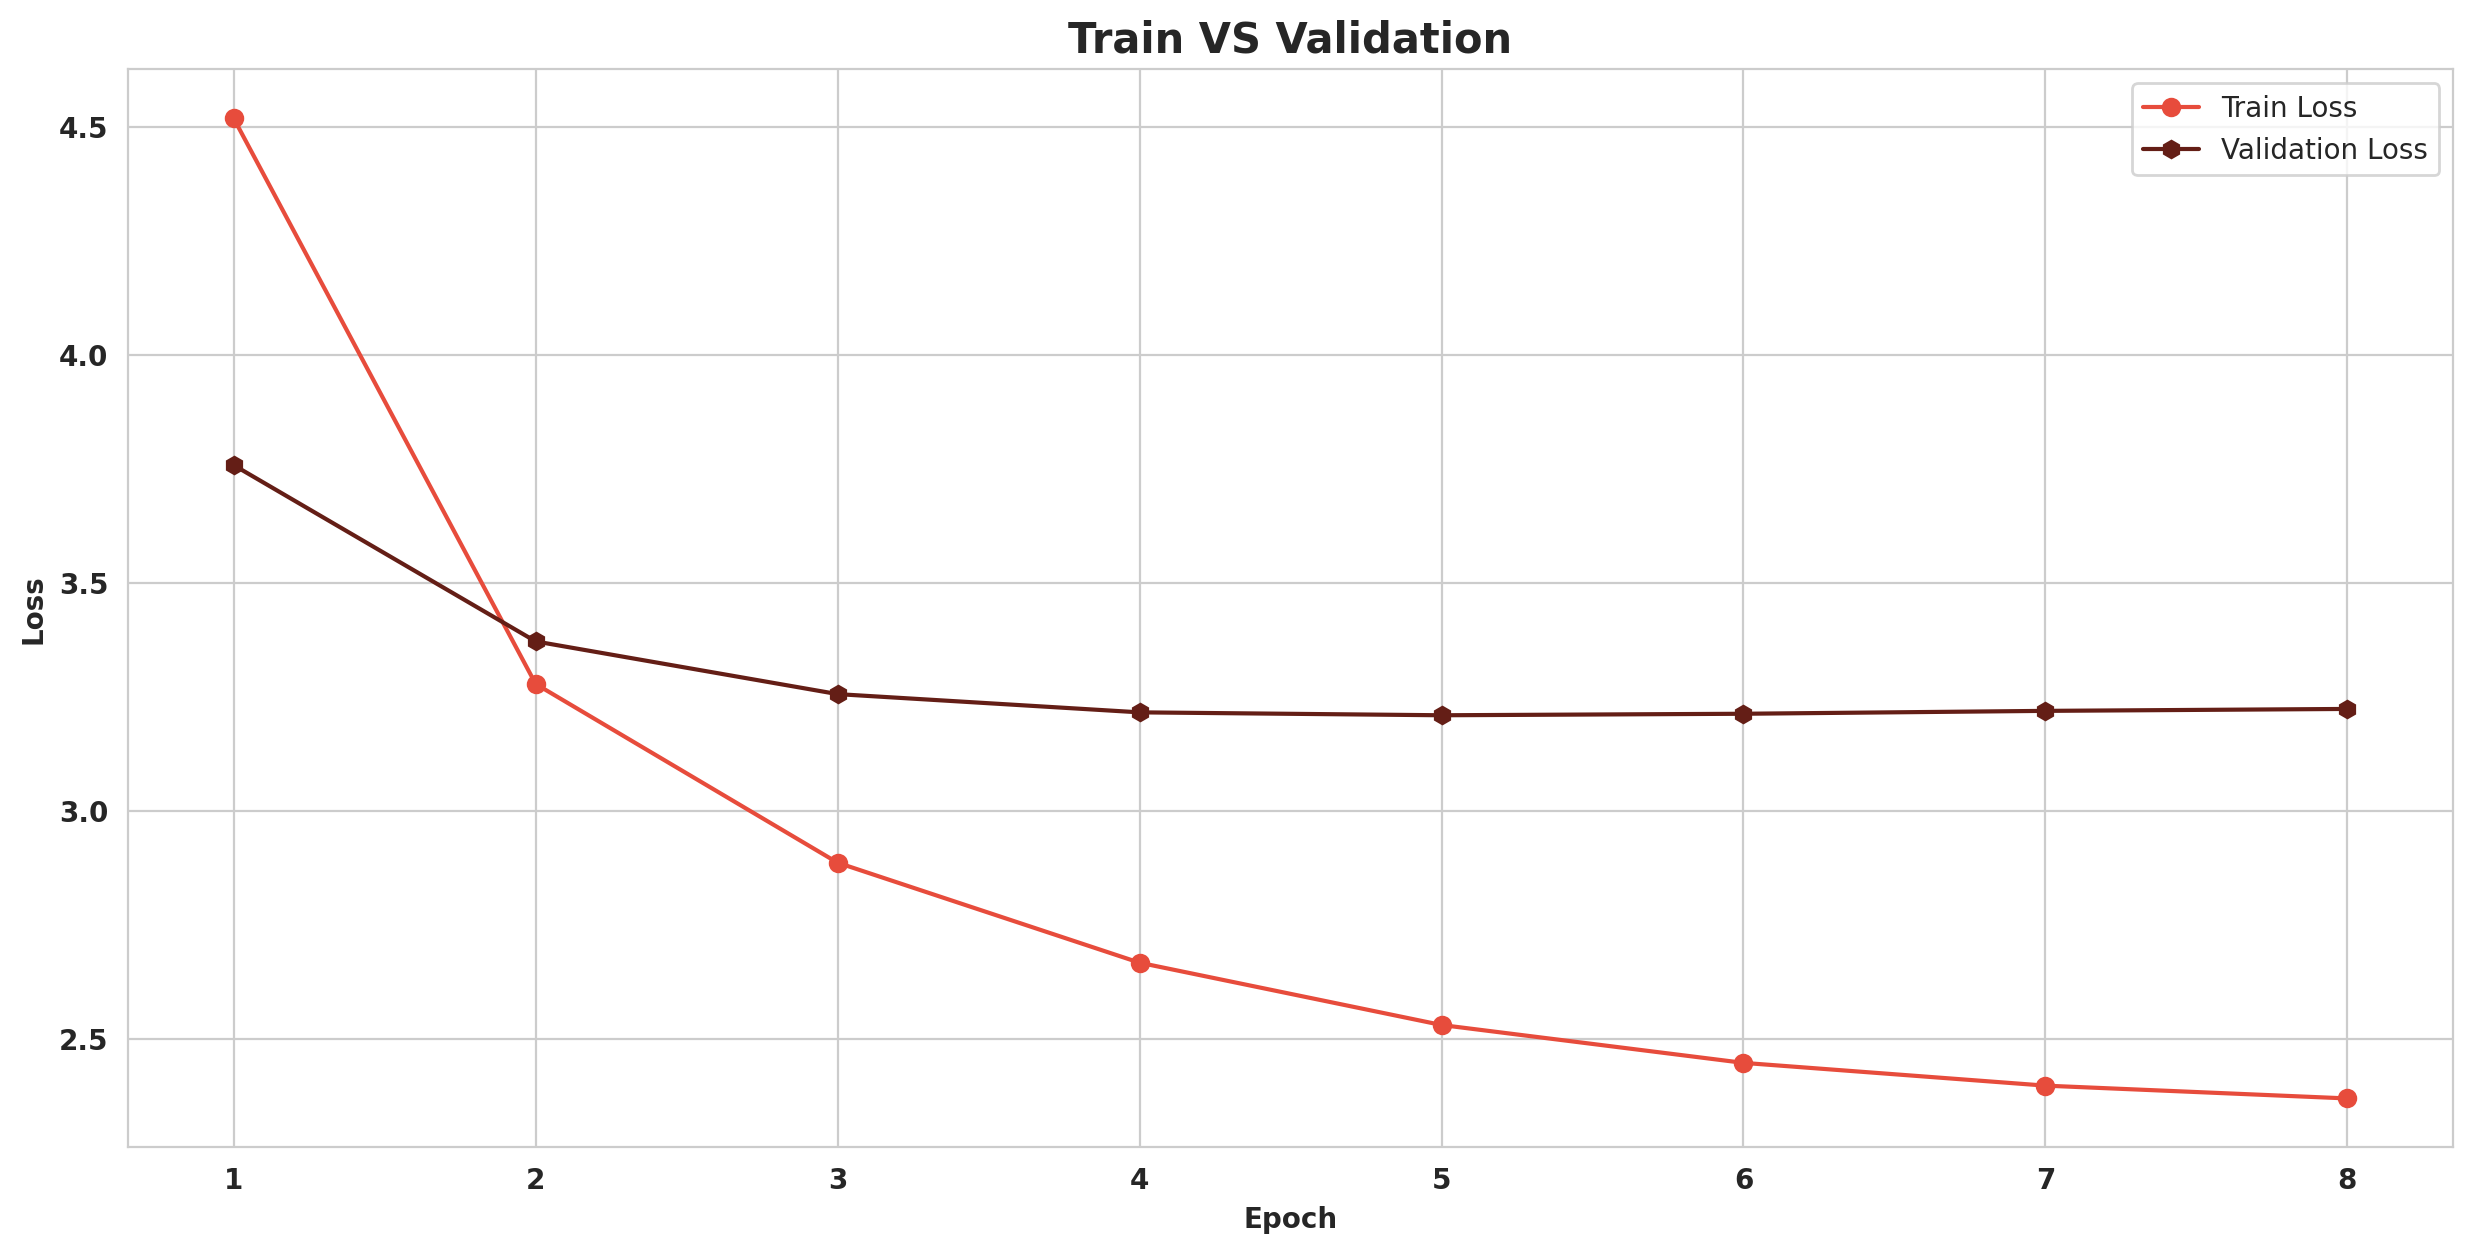

In [ ]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

In [ ]:
def pred_generator(image_features): # A function to generate captions
    # Each caption is started with the word 'start'
    in_text = 'start '
    for _ in range(caption_max_length):
        sequence = tokenizer_instance.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=caption_max_length).reshape((1,caption_max_length))
        prediction = caption_model.predict([image_features.reshape(1,output_dim_of_cnn_model), sequence], verbose=0)
        # finds the index of the word with the highest probability in the output prediction.
        idx = np.argmax(prediction)
        word = tokenizer_instance.index_word[idx]
        # Adding the predicted word to the sequence
        in_text += ' ' + word

        if word == 'end':
            break

    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')

    return in_text

In [ ]:
# Calculates BLEU score of predictions
def BLEU_score(actual, pred):
    # Calculating the BLEU score by comparing the predicted caption with five actual captions.
    score_pred_1 = corpus_bleu(actual, pred)

    return [
        (f'BLEU-1 Beam Search: {round(score_pred_1, 5)}'),
        (f'pred: {pred[0]}')
    ]

In [ ]:
# A dictionary to access actual captions of each image by its ID
test_actual_captions = {}
for item in test_id_and_captions:
    image_id, caption = item.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)

In [ ]:
# Generating captions
generated_captions = {}

for image_id in test_image_features:
    cap = pred_generator(test_image_features[image_id])
    generated_captions[image_id] = cap

# bleu_score_return = def BLEU_score(test_actual_captions[image_id], generated_captions[image_id])